# Generalized Additive Model (GAM) for regression tasks

This example illustrates the use of GAMs for regression tasks. When using GAMs for regression tasks, 
we can typically use the `LinearGAM()` class in pyGAM which models:

$$\mathbb{E}[y | X] = \beta_0 + f_1(X_1) + f_2(X_2, X_3) + \dots + f_M(X_N)$$

We'll use the [medical insurance cost prediction dataset available from Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance):

The dataset consists of 5 features such as age, sex, bmi, number of children, whether the client is a smoker and the region where they live. These features are used to predict cost of medical insurance. It is a fairly simple dataset to illustrate the use of GAMs for regression.






## **1. Load and preprocess the dataset**


We will load the dataset and apply normalization and label encoding to the dataset before using scikit-learn to split the dataset into train and validation.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from pygam import LinearGAM, s, f
import joblib
import math

np.random.seed(42)

#----------------------------
# 1. Load and Preprocess Data
# -----------------------------
def load_data():
    # Adjust the path as needed
    return pd.read_csv('../../datasets/insurance/insurance.csv')

def preprocess_data(data):
    # Make copies to preserve original numerical values
    data_processed = data.copy()
    data_numerical_orig = data_processed.copy()
    
    # Identify categorical and numerical columns.
    categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Remove the target variable 'charges' from numerical_columns if present.
    if 'charges' in numerical_columns:
        numerical_columns.remove('charges')
    
    # For categorical features, use LabelEncoder and store mapping.
    cat_mapping = {}
    for col in categorical_columns:
        le = LabelEncoder()
        data_processed[col] = le.fit_transform(data_processed[col])
        # Save the original class labels (in order of encoding)
        cat_mapping[col] = list(le.classes_)
    
    # For numerical features, store original values.
    data_numerical_orig = data_numerical_orig[numerical_columns]
    
    # Scale numerical features
    scaler = StandardScaler()
    data_processed[numerical_columns] = scaler.fit_transform(data_processed[numerical_columns])
    
    return data_processed, scaler, cat_mapping, data_numerical_orig, numerical_columns

# Load and preprocess the data
df = load_data()
df_processed, scaler, cat_mapping, data_numerical_orig, numerical_columns = preprocess_data(df)
print("Processed data head:")
display(df_processed.head())



# -----------------------------
# 2. Split Data for Training and Testing
# -----------------------------

X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)








Processed data head:


,age,sex,bmi,children,smoker,region,charges
0,-1.438764,0,-0.453320,-0.908614,1,3,16884.92400
1,-1.509965,1,0.509621,-0.078767,0,2,1725.55230
2,-0.797954,1,0.383307,1.580926,0,2,4449.46200
3,-0.441948,1,-1.305531,-0.908614,0,1,21984.47061
4,-0.513149,1,-0.292556,-0.908614,0,1,3866.85520


## 

## **2.Define a GAM model for regression**

Next, we define the GAM model, in this case the `LogisticGAM` model. We specify a smooth term for numerical features and factor term for categorical featurs. 

- Smooth terms model continuous variables non-parametrically using splines. They capture nonlinear relationships between predictors and the response without assuming a specific functional form. PyGAMs use penalized B-splines and the number of spline basis functions (`n_splines`)determine how smooth the function is.

- Factor terms handle categorical variables. They allow separate effects for each categry without assuming any ordering.

In the following example, we limit the number of splines to 5 (allowing for smoother function and thereby faster computation.) `lam` refers to lambda which is a penalty - higher the value, the smoother the finction. This hyperparameter can be also set using grid search.


In [4]:

# Build model specification: smooth for numerical, factor for categorical.
terms = None
for i, col in enumerate(X_train.columns):
    if col in numerical_columns:
        new_term = s(i)
    else:
        new_term = f(i)
    terms = new_term if terms is None else terms + new_term

gam = LinearGAM(terms, n_splines=5, lam=0.01).fit(X_train.values, y_train.values)
print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.1224
Link Function:                     IdentityLink Log Likelihood:                                -19620.8255
Number of Samples:                         1070 AIC:                                            39277.8958
                                                AICc:                                           39278.5553
                                                GCV:                                         37786622.4563
                                                Scale:                                       36699788.5158
                                                Pseudo R-Squared:                                   0.7498
Feature Function                  Lam

/var/folders/yb/vfxxb21x1p94qtd90h1zgvl40000gq/T/ipykernel_9311/4065900755.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


### Comments:

We see the fitted model has 17 effective DoF. Its fairly flexible, but not overly complex. The PSeudo R-suared is around 0.75 which means the model explains around 75% of teh variance, which is a good fit.

### Warning

Large dataset size or large `n_splines` size can increase training time and memory exponentially. If you undergo OOM error or if Juputer crashes, start with a very small `n_splines` size (for ex: n_splines=5).


## **4.Evaluate the model**

Optinally, we can run the prediction on the test set.

In [10]:

y_pred = gam.predict(X_test)
mse = np.mean((y_test - y_pred)**2)
mae = np.mean(np.abs(y_test - y_pred))
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")




Mean Squared Error: 33472337.1988
Mean Absolute Error: 4227.9628
Root Mean Squared Error: 5785.5283


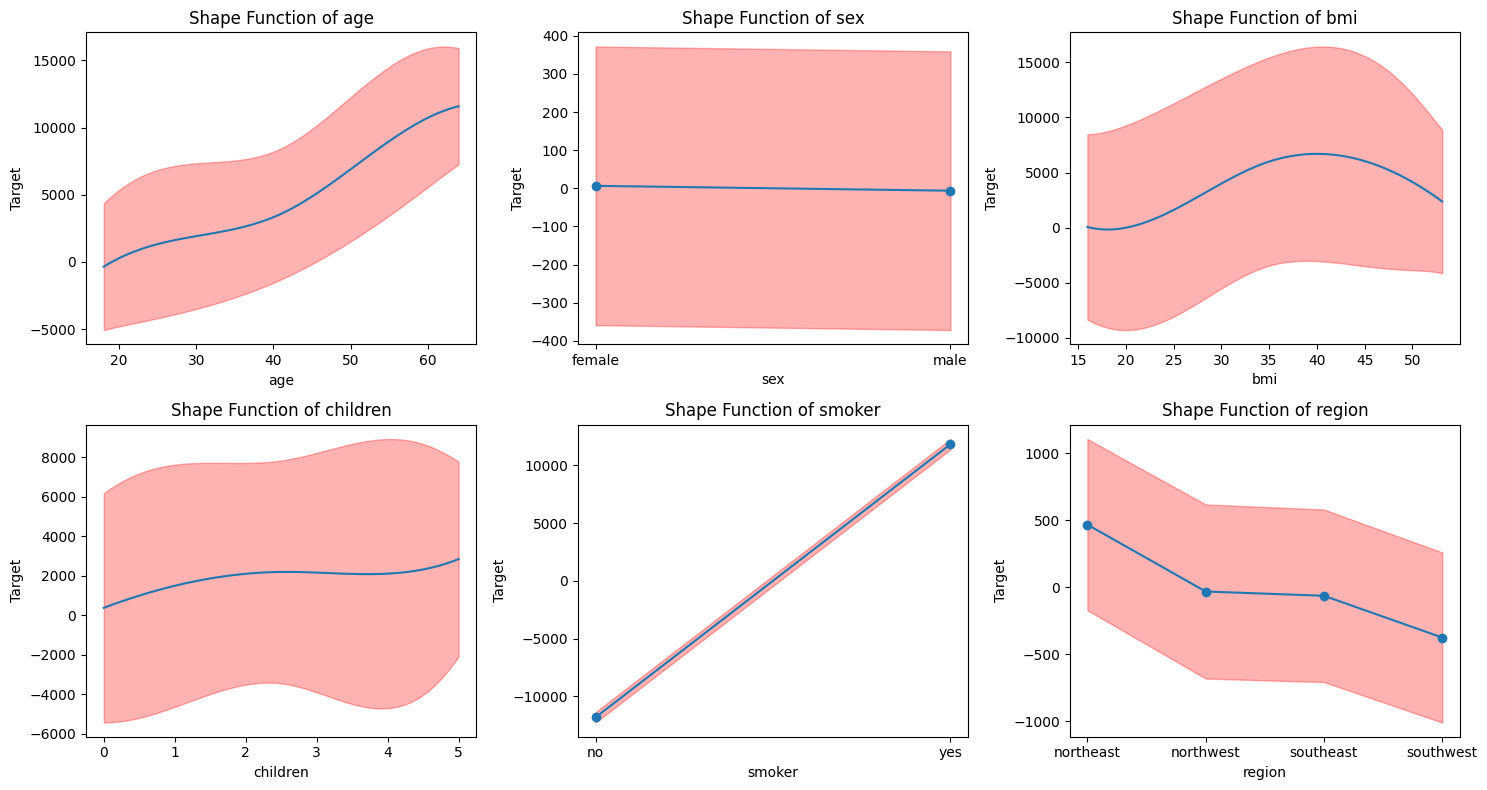

In [ ]:

# -----------------------------
# 5. Plot Partial Dependence for All Features
# -----------------------------
feature_names = X_train.columns
n_features = len(feature_names)

# Create a mapping for numerical features: feature -> (mean, std)
num_stats = {}
for col in numerical_columns:
    j = numerical_columns.index(col)
    mean = scaler.mean_[j]
    std = np.sqrt(scaler.var_[j])
    num_stats[col] = (mean, std)

# Baseline row: use the mean of the scaled X_train for all features.
baseline_row = X_train.values.mean(axis=0)

# Determine subplot grid dimensions
ncols = math.ceil(np.sqrt(n_features))
nrows = math.ceil(n_features / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axs = axs.ravel()

# For each feature, create a full X matrix based on baseline values.
for idx in range(n_features):
    feature = feature_names[idx]
    term_idx = int(idx)
    
    if feature in numerical_columns:
        grid_points = 100
        # Create baseline matrix with grid_points rows.
        X_baseline = np.tile(baseline_row, (grid_points, 1))
        # Get original range for this numerical feature
        orig_vals = data_numerical_orig[feature]
        orig_min, orig_max = orig_vals.min(), orig_vals.max()
        grid_orig = np.linspace(orig_min, orig_max, grid_points)
        # Convert grid to scaled values using (mean, std)
        mean, std = num_stats[feature]
        grid_scaled = (grid_orig - mean) / std
        X_baseline[:, term_idx] = grid_scaled
        pdep, confi = gam.partial_dependence(term=term_idx, X=X_baseline, width=0.95)
        axs[idx].plot(grid_orig, pdep)
        axs[idx].fill_between(grid_orig, confi[:, 0], confi[:, 1], color='r', alpha=0.3)
        axs[idx].set_xlabel(feature)
    else:
        # For categorical features
        levels = cat_mapping[feature]
        grid_points = len(levels)
        X_baseline = np.tile(baseline_row, (grid_points, 1))
        grid_factor = np.arange(grid_points)
        X_baseline[:, term_idx] = grid_factor
        pdep, confi = gam.partial_dependence(term=term_idx, X=X_baseline, width=0.95)
        axs[idx].plot(grid_factor, pdep, marker='o')
        axs[idx].fill_between(grid_factor, confi[:, 0], confi[:, 1], color='r', alpha=0.3)
        axs[idx].set_xticks(grid_factor)
        axs[idx].set_xticklabels(levels)
        axs[idx].set_xlabel(feature)
    
    axs[idx].set_ylabel("Target")
    axs[idx].set_title(f"Shape Function of {feature}")

# Hide any extra subplots if n_features is not a perfect grid.
for k in range(n_features, len(axs)):
    fig.delaxes(axs[k])

plt.tight_layout()
plt.savefig('GAM_regression.png')
plt.show()


## Interpretation

1. Age

- Older individuals tend to have higher predicted insurance charges. The slope’s shape can indicate how quickly charges rise with age. In many insurance contexts, costs increase more steeply in later years.
  
2. Sex
- The model does not find a strong difference in insurance charges between the two sexes (after controlling for the other features like age, BMI, smoker, etc.). If the partial dependence is nearly zero, it suggests sex isn’t a major driver of cost in this dataset (or that it’s overshadowed by stronger features).
  
3. BMI

- Higher BMI is associated with higher predicted charges. The model captures that individuals with higher BMI generally incur more medical costs, consistent with the notion that higher BMI can correlate with health risks.

4. Children

- Having more children slightly increases predicted charges. This makes sense because insurance plans often cost more when covering additional family members.

5. Smoker
- Smoking status is by far one of the biggest cost drivers in this dataset. Smokers have substantially higher predicted charges, which aligns with the well‐known increase in healthcare costs associated with smoking‐related conditions.
  
6. Region
- The plot shows different partial dependence values for each region.
Interpretation: There is some variation by region, though typically smaller than the difference seen for smoking or age. One region might be slightly higher or lower in predicted costs. This could reflect differences in healthcare costs, local lifestyle factors, or demographics specific to each region.